# Project A3:  Approximate Membership Filters  
## 1. Introduction

Approximate membership filters are compact data structures that answer set-membership queries quickly with a small false positive rate. In this project, we implement and compare Blocked Bloom, XOR, Cuckoo, and Quotient filters to study their trade-offs in space efficiency, accuracy, throughput, and scalability. We evaluate both static and dynamic filters under different workloads, load factors, and thread counts to understand when each design performs best and what system factors limit performance. 

## 2. Methodology

### 2.1 Experimental Environment

CPU: AMD Ryzen 5 7600X | 4691.105Mhz

6 physical cores, 2 threads per core(SMT)

Cache hierarchy:

L1d: 32 KB per core × 6

L1i: 32 KB per core × 6

L2: 1 MB per core × 6

L3: 32 MB shared

OS: Ubuntu 24.04.3 LTS

gcc: gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0

Compiler flags:
- O3 optimization
- -march=native
- pthread enabled

NUMA:       
             
NUMA node(s):           1

NUMA node0 CPU(s):      0-11

Flags: SSE, AVX, AVX2, AVX512, AVX512f

SMT policy:

Experiments scale up to 12 threads, spanning both physical cores and SMT siblings.

### 2.2 Setup & Measurement Method

**Blocked Bloom:**

Requires ~9–10 bits per entry at 1% FPR, offers O(k) lookups with good cache locality, but does 

not support deletions.

**XOR:**

Static filter using ~8–9 bits per entry with sub-0.5% false positive rate and O(1) query time, 

but no dynamic updates.

**Cuckoo:**

Dynamic filter with ~8–16-bit fingerprints, supporting insert and delete with bounded kick-outs 


(hundreds at high load)

**Quotient:**

Dynamic filter storing quotient–remainder pairs using ~8–16 bits per entry, achieving high 

space efficiency while cluster lengths remain small


**Metrics:**

Throughput (ops/s): Measured as the total number of operations (lookups, inserts, and deletes) divided by the execution time.

Insert Throughput (ops/s): Number of successful insert operations per second, reported as a function of load factor.

Delete Throughput (ops/s): Number of successful delete operations per second, reported as a function of load factor.

Lookup Throughput (ops/s): Number of query operations per second, evaluated under different negative lookup ratios.

Bits Per Entry (BPE): Total memory usage of the filter (including metadata) divided by the number of inserted keys

False Positive Rate (FPR): Ratio of false positives to total negative queries, measured on an independent key set.

Insertion Failure Rate (Cuckoo): Fraction of insert attempts that fail due to bounded kick-out limits.

Average Probe Length (Cuckoo): Average number of probe steps or relocations per successful insert.

Kick-out Count (Cuckoo): Total number of evictions triggered during insert operations, indicating insertion complexity at high load.

Stash Insert Count (Cuckoo): Number of entries placed into the stash when regular insertion fails.

Cluster Length Statistics (Quotient): Distribution of contiguous cluster sizes, reported using p50, p95, p99, and maximum cluster length.

Thread Scaling Speedup: Defined as the throughput at T threads divided by the throughput at a single thread.

**Workloads**

1. lookup-only

2. insert-only

3. mixed 70/30

Repeats: 3

**Dataset sizes**

1e4, 1e5, 1e6 keys

**Thread scaling**

T = [1, 2, 4, 8, 12]

Run: 

In [ ]:
gcc -O3 -std=c11 bb.c ck.c qf.c xor.c exp1.c -lm -o exp1
./exp1 1000000 1000000 > exp1.csv

python3 plot1.py exp1.csv

gcc -O3 -std=c11 bb.c ck.c qf.c xor.c exp2.c -lm -o exp2
./exp2 1000000 1000000 > exp2.csv

python3 plot2.py exp2.csv

gcc -O3 -std=c11 ck.c qf.c exp3.c -lm -o exp3
./exp3 1000000 > exp3.csv

python3 plot3.py

gcc -O3 -std=c11 -pthread ck.c qf.c exp4.c -lm -o exp4

echo "workload,filter,bits,threads,load,throughput_mops,total_ops,reads,ins,del,ins_ok,del_ok,pin" > exp4.csv

for th in 1 2 4 8 12; do
  ./exp4 Cuckoo   12 1000000 0.85 $th 500 2000 readmostly 1 >> exp4.csv
  ./exp4 Quotient 12 1000000 0.85 $th 500 2000 readmostly 1 >> exp4.csv
done

for th in 1 2 4 8 12; do
  ./exp4 Cuckoo   12 1000000 0.85 $th 500 2000 balanced 1 >> exp4.csv
  ./exp4 Quotient 12 1000000 0.85 $th 500 2000 balanced 1 >> exp4.csv
done

python3 plot4.py


# 3. Results

## 3.1 Space vs accuracy: 

### bpe/fpr
| 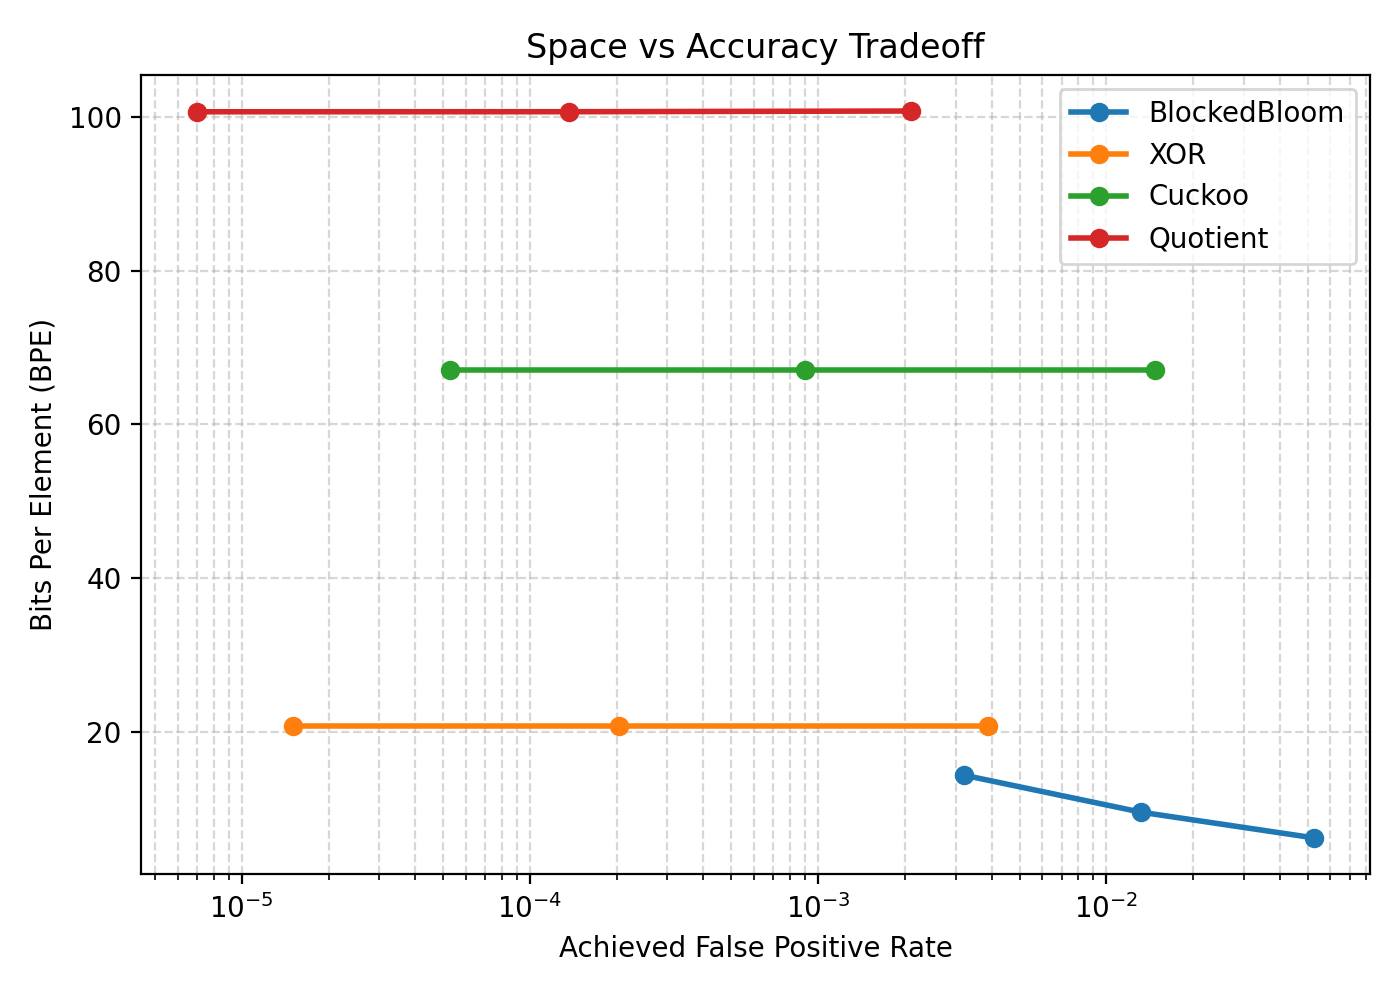 | 
|:----------------------------------------------------:|

Overall, Blocked Bloom achieves the lowest space cost at higher FPRs. However, its achieved FPR is relatively high and less tightly controlled, which is very efficient, but with weaker accuracy guarantees.

XOR stands out as the most space-efficient structure at low and medium FPRs. It consistently stays around ~20 bits per entry while achieving very low false positive rates.

Cuckoo filters sit in the middle. Their BPE is higher than XOR due to per-bucket structure and metadata, but remains stable across different FPRs. This reflects the overhead needed to support dynamic inserts and deletes.

the Quotient filter has the highest BPE across all FPRs. The large space cost may comes from its metadata bits which dominate the storage overhead. In return, it supports fully dynamic operations and cache-friendly scans, but trades space for flexibility.

### build time

| 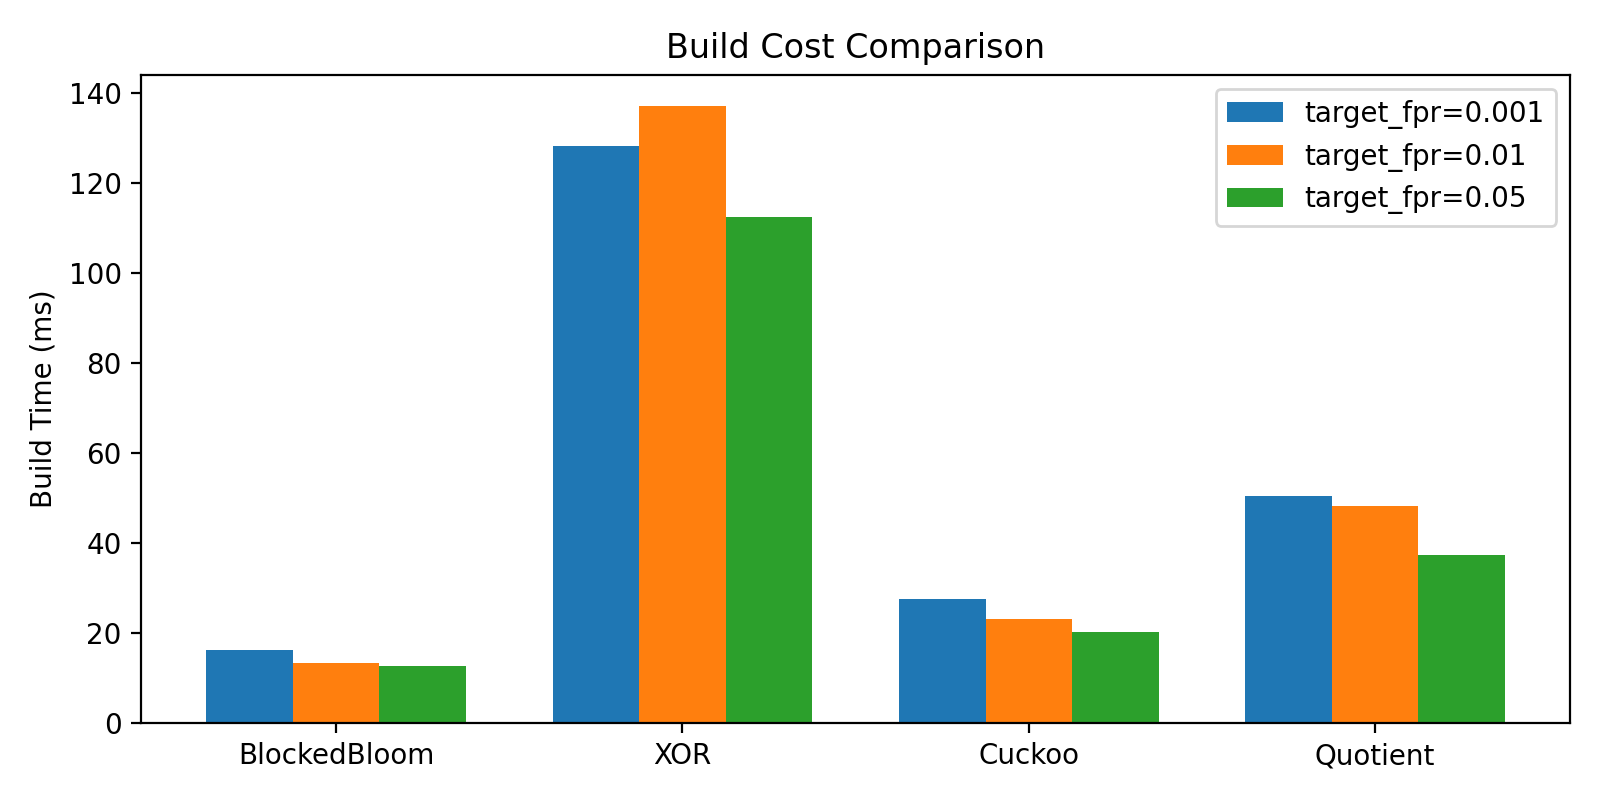 | 
|:----------------------------------------------------:|

XOR filters pay a high upfront build cost for superior space efficiency, while Bloom filters are cheap to build, and Cuckoo and Quotient filters strike a balance by supporting dynamic operations with reasonable construction overhead.


### target/achieved
| 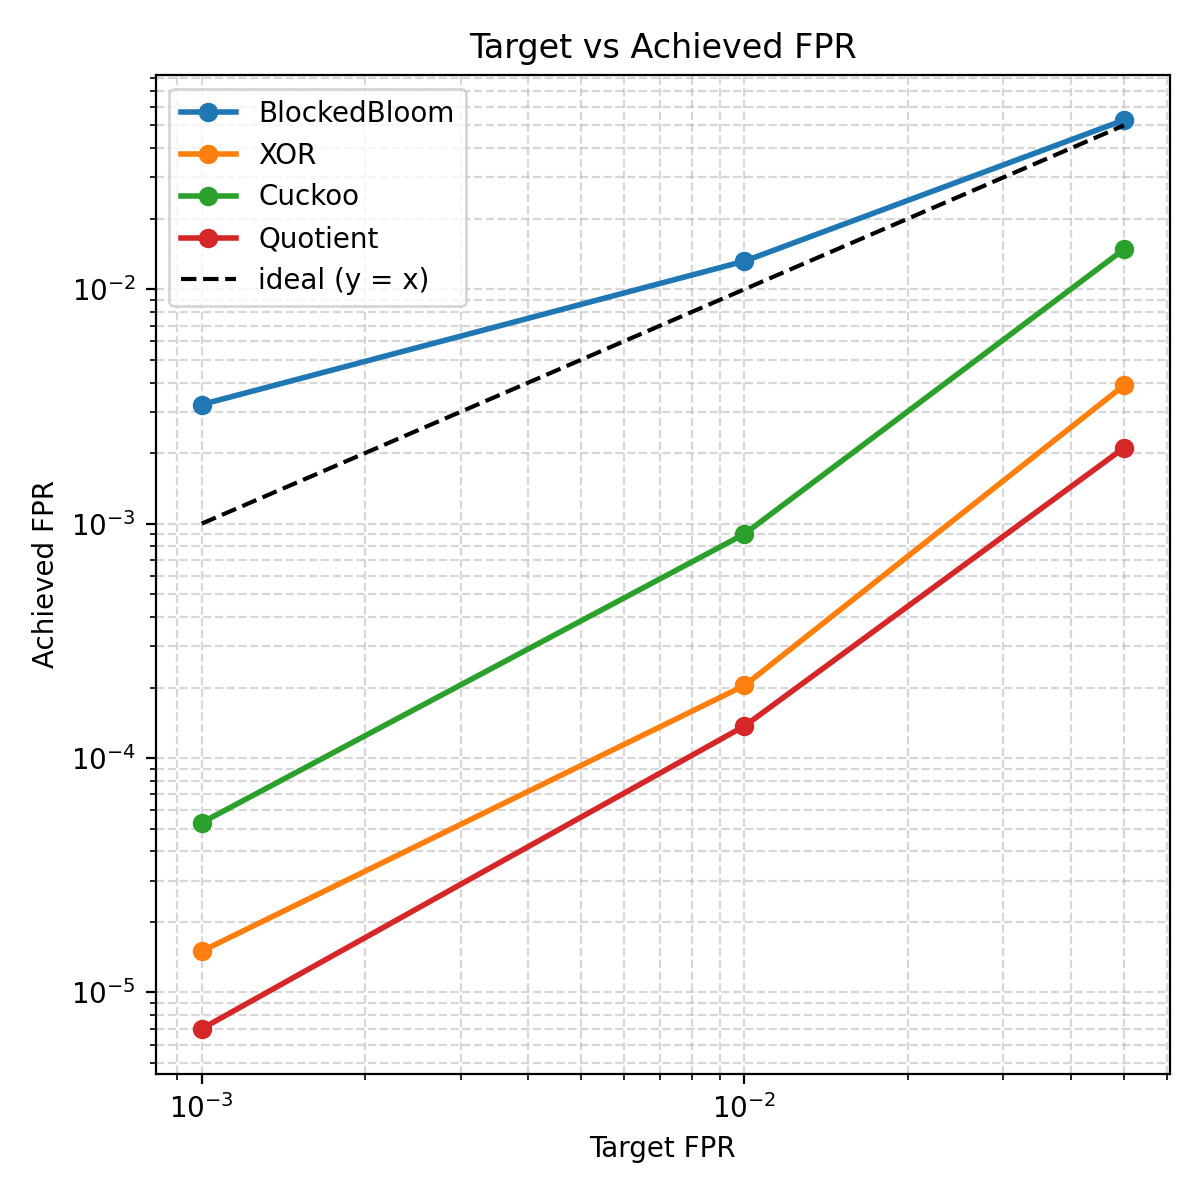 | 
|:----------------------------------------------------:|

The XOR filter follows the ideal line most closely, indicating very precise and predictable FPR control. The Quotient filter also tracks the target well, especially at lower FPRs, with slight conservative bias due to metadata handling. The Cuckoo filter shows larger deviations, particularly at higher FPRs, which is expected given bucket limits and evictions. In contrast, the Blocked Bloom filter consistently exceeds the target FPR, reflecting its approximate nature and weaker accuracy control.


## 3.2 Lookup throughput & tails:

We conduct a evaluation of lookup throughput and latency tails (p50/p95/p99) for all four filters under increasing negative-lookup ratios and different target false positive rates.Figures are in (results & figures / figs_exp2) folder. Here we pick some representative figures to analyze:

| 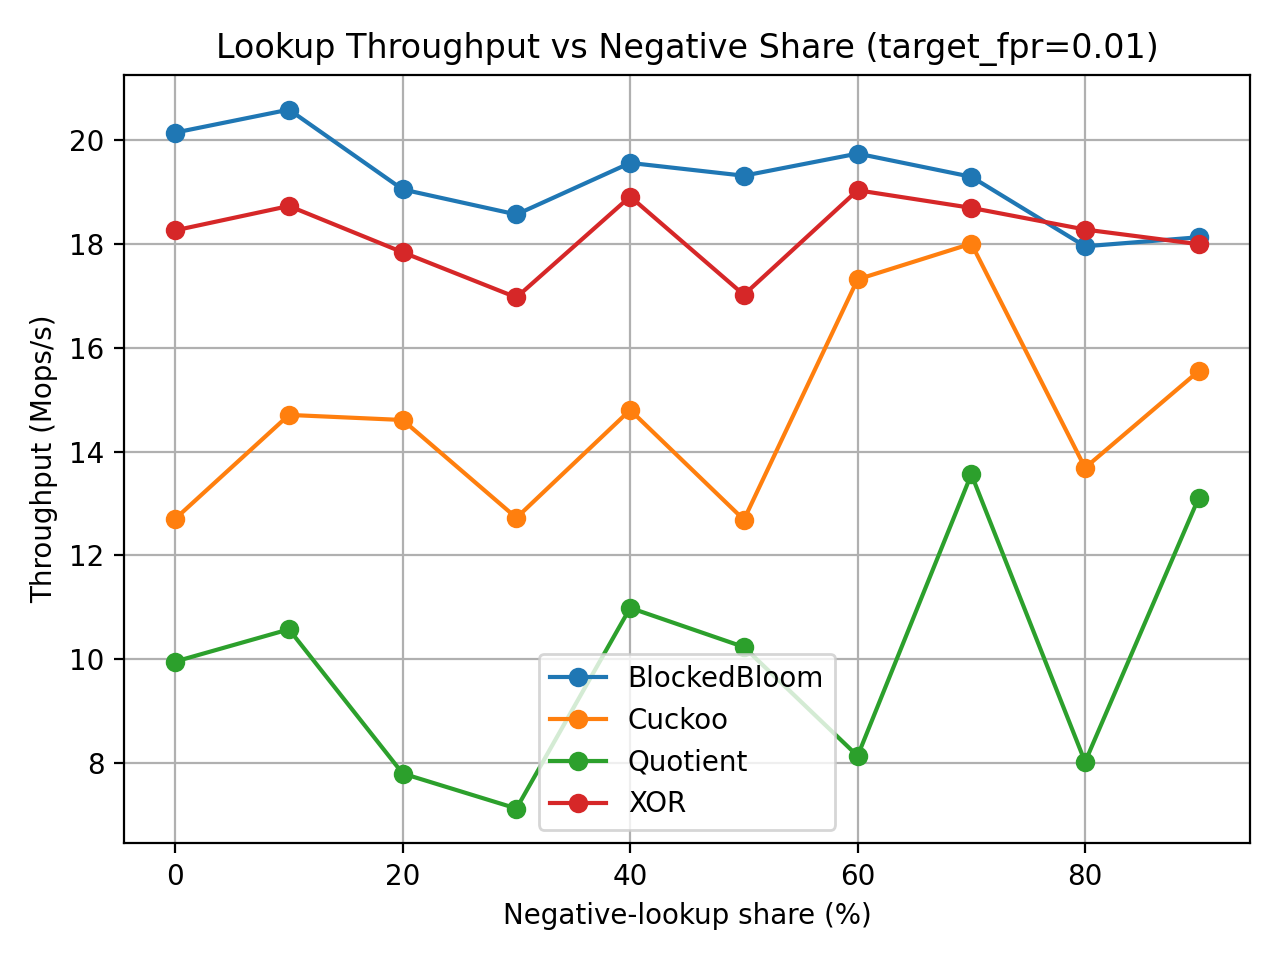 | 
|:----------------------------------------------------:|

As the negative-lookup share increases, lookup throughput remains relatively stable for Blocked Bloom and XOR filters, indicating strong cache-friendly behavior and predictable control flow. XOR consistently achieves high throughput, while Blocked Bloom performs best overall. In contrast, Cuckoo and Quotient filters show larger throughput fluctuations, especially at higher negative rates, reflecting more irregular memory accesses and longer probe chains. This trend also shows in 0.1% FPR and 5% FPR.

| 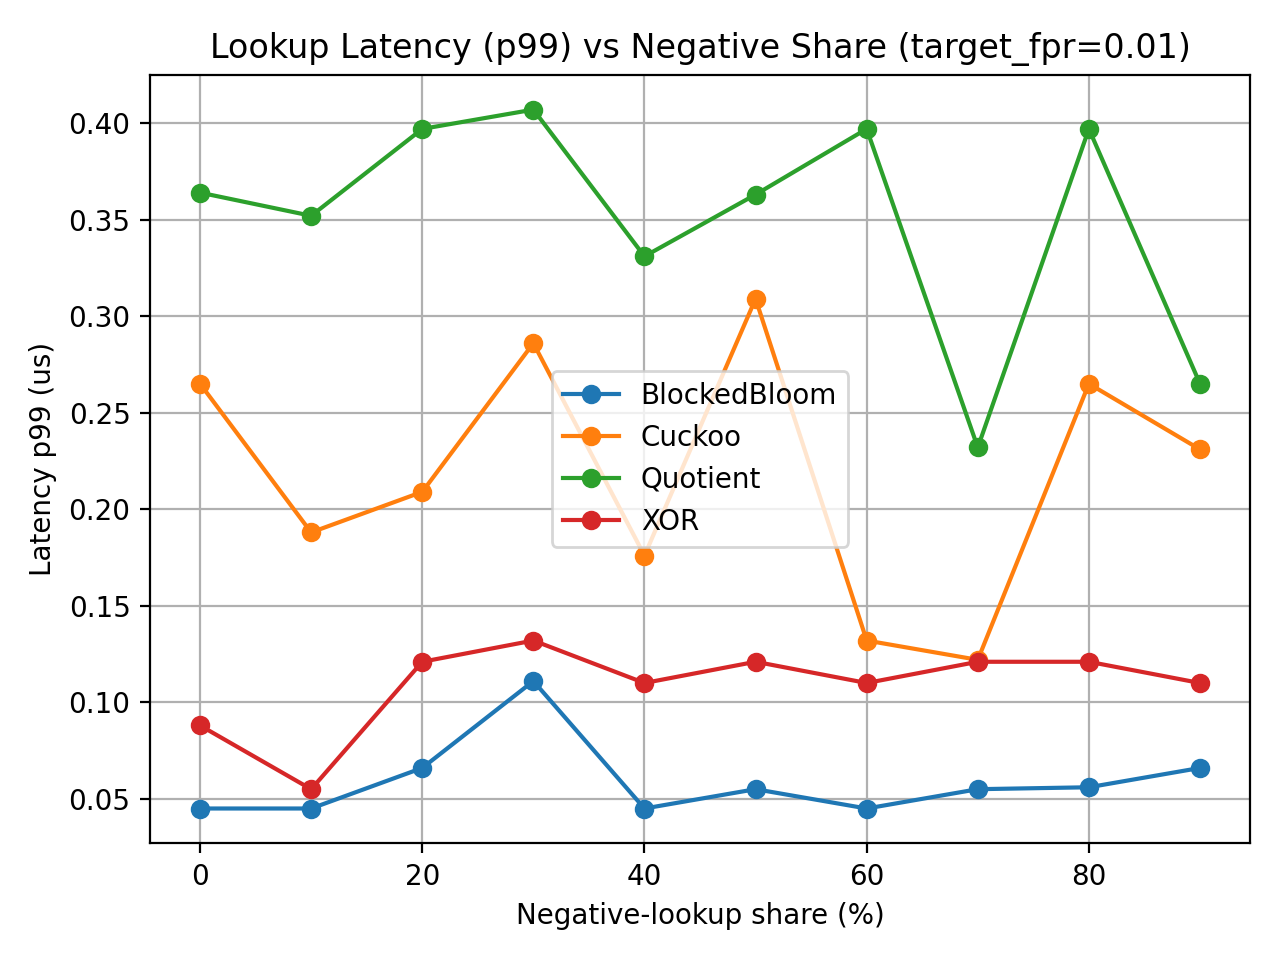 | 
|:----------------------------------------------------:|

The p99 latency highlights clear differences in tail behavior across filters. Blocked Bloom and XOR maintain consistently low tail latency across all negative-lookup shares, reflecting short and bounded probe paths. In contrast, Cuckoo and especially Quotient filters exhibit significantly higher and more variable p99 latency, indicating occasional long probe chains and cache-unfriendly access patterns. As the negative share increases, these effects become more pronounced, showing that tail latency is dominated by worst-case probe behavior rather than average throughput.

As the target FPR decreases, median latency (p50) remains largely unchanged across all filters, since typical lookup paths are unaffected. However, tail latency (p95/p99) increases for dynamic filters, especially Cuckoo and Quotient.



## 3.3 Insert/delete throughput

| 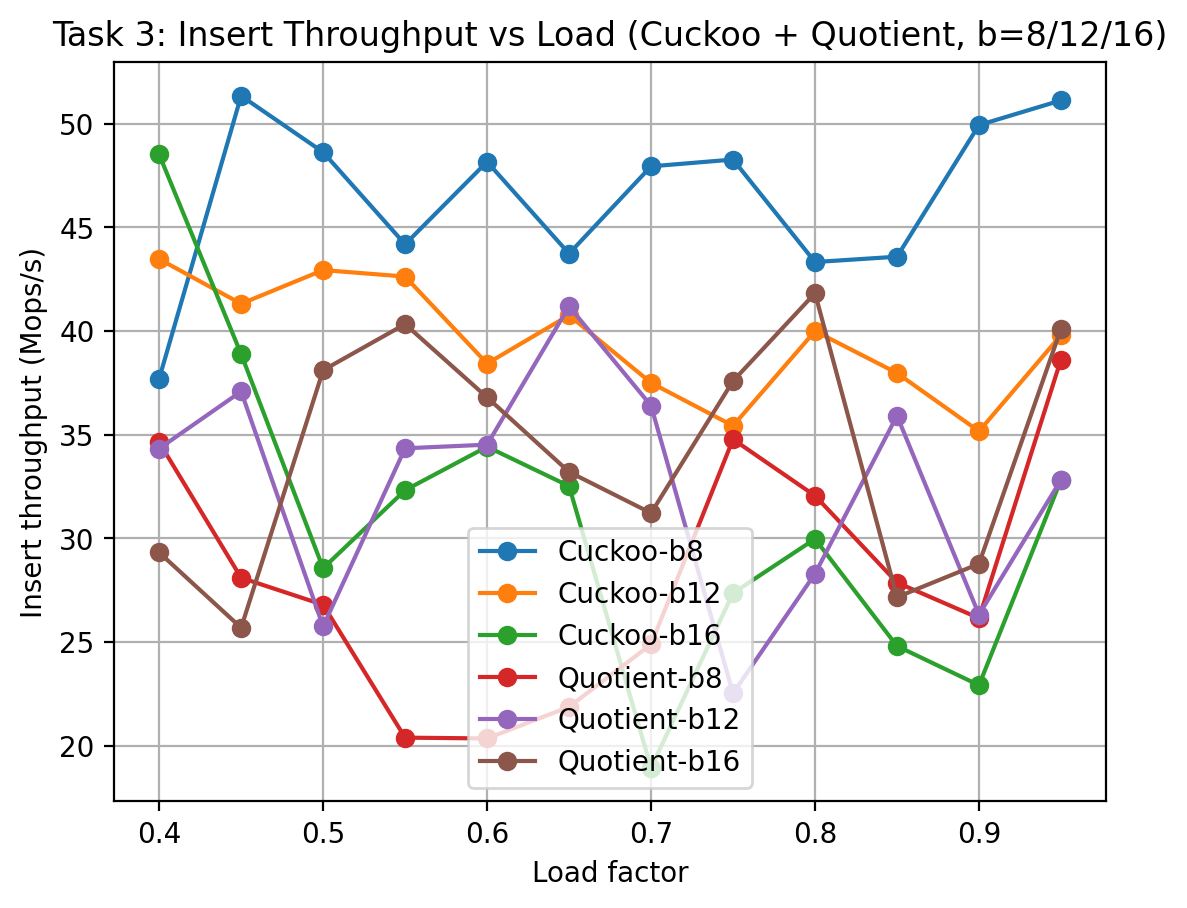 | 
|:----------------------------------------------------:|

Across all load factors, Cuckoo achieves about 45–52 Mops/s at 8 bits, dropping to roughly 38–45 Mops/s at 12 bits and 30–40 Mops/s at 16 bits, showing a clear throughput penalty as fingerprint size increases. In contrast, Quotient operates at lower rates, typically 20–40 Mops/s, and exhibits larger fluctuations as load grows. At high load (≥0.8), Quotient throughput can drop by 20–30%, while Cuckoo remains relatively stable. Overall, Cuckoo sustains higher and more predictable insert performance, whereas Quotient is more sensitive to both load factor and fingerprint width.

| 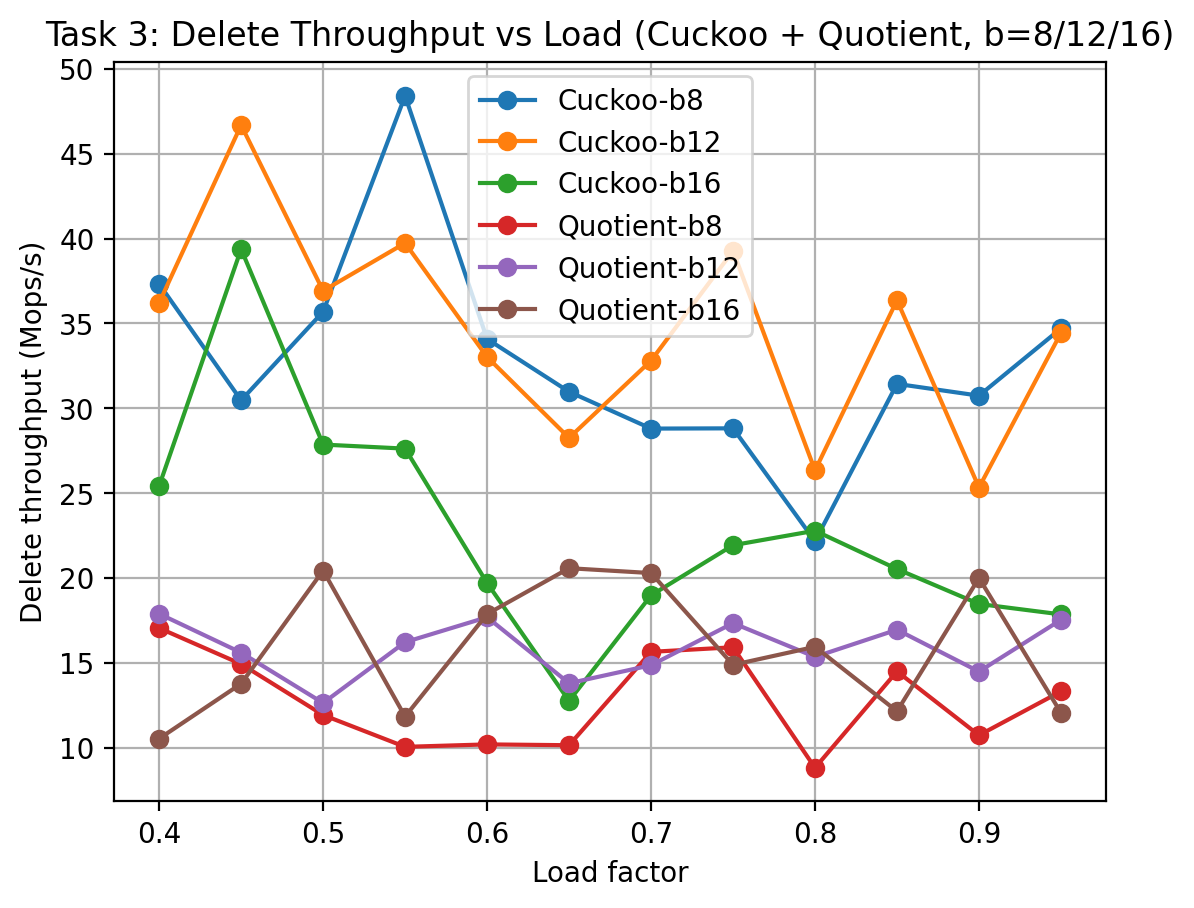 | 
|:----------------------------------------------------:|

Delete throughput is generally lower than insert throughput for both filters. Cuckoo maintains higher delete performance, reaching about 30–48 Mops/s at 8–12 bits, while 16-bit fingerprints drop to roughly 18–25 Mops/s as load increases. Quotient delete throughput is significantly lower, typically 10–18 Mops/s, and degrades more noticeably at high load (≥0.8).


| 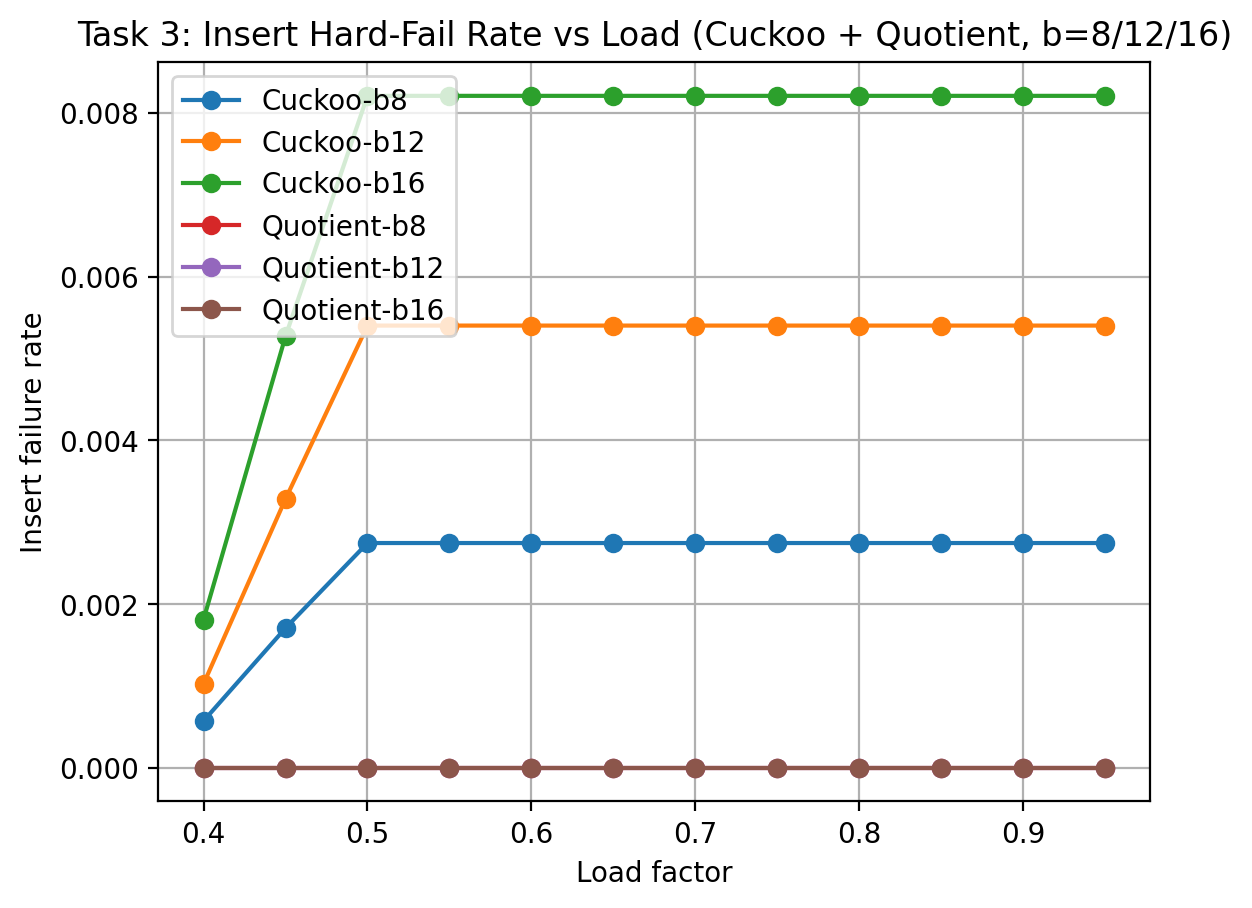 | 
|:----------------------------------------------------:|

Insert hard-failures occur only in the Cuckoo filter, and the failure rate increases with both load factor and fingerprint size. At moderate load (≈0.5), the failure rate stabilizes around 0.25–0.3% for 8 bits, ~0.5% for 12 bits, and ~0.8% for 16 bits, and remains roughly constant as load continues to rise. In contrast, Quotient shows zero insertion failures across all loads and fingerprint widths, highlighting its robustness for dynamic inserts.

| 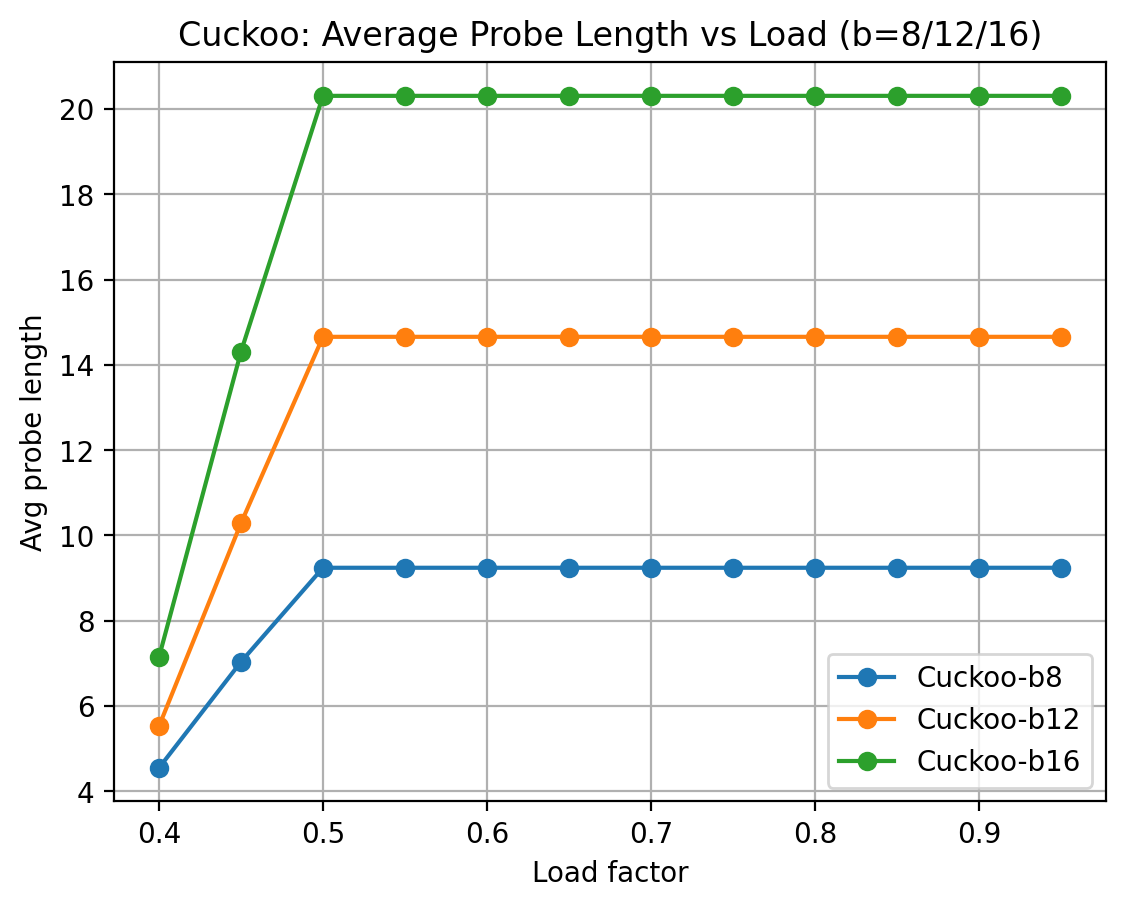 | 
|:----------------------------------------------------:|

Average probe length in Cuckoo filters increases sharply as load approaches 0.5, then saturates and remains stable afterward. At steady state, the average probe length is about 9 probes for 8-bit, 15 probes for 12-bit, and ~20 probes for 16-bit fingerprints. Larger fingerprints consistently incur longer probe chains due to higher relocation pressure during insertions. The flat curves beyond load ≈0.5 indicate that bounded evictions effectively cap probe growth, but at the cost of higher per-insert work, which explains the throughput degradation observed at higher loads.

| 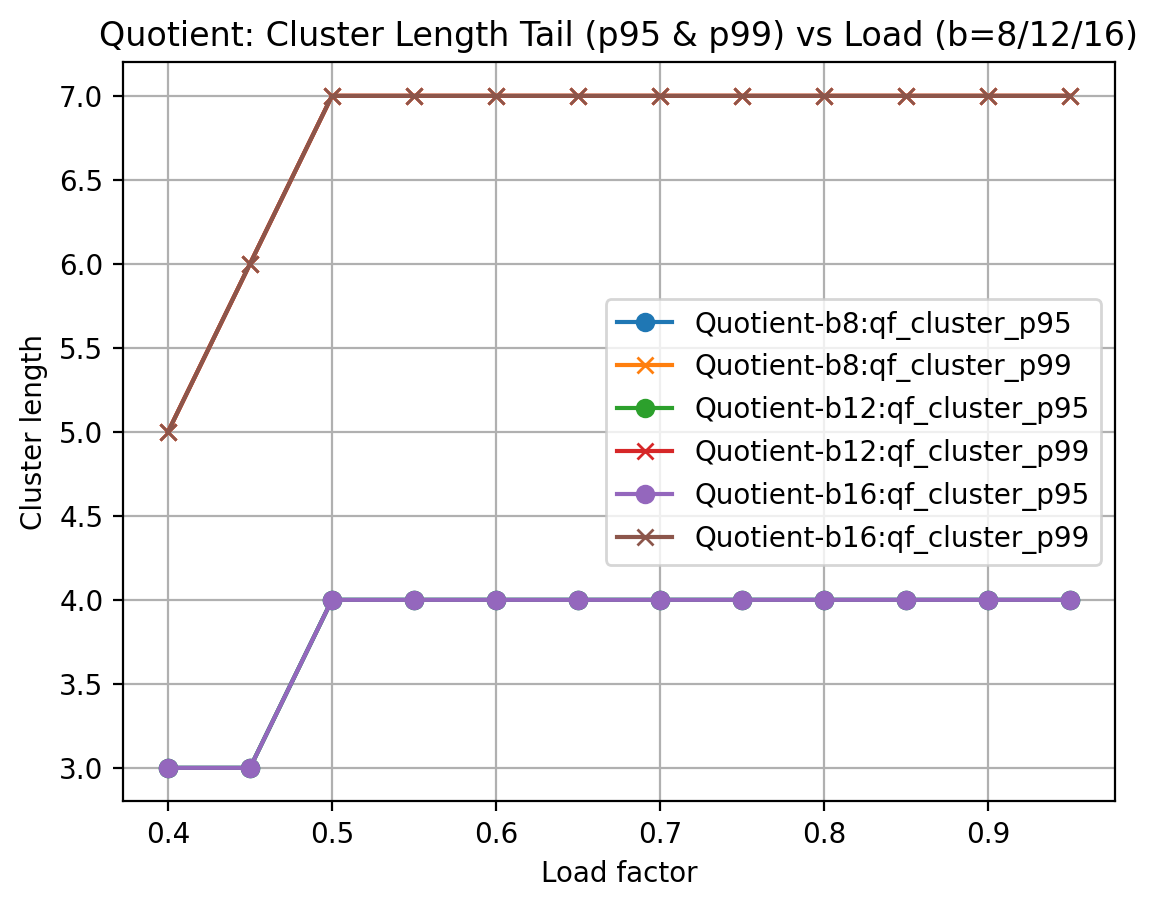 | 
|:----------------------------------------------------:|

At steady state, the p95 cluster length stabilizes at about 4, while the p99 stabilizes around 7, consistently across fingerprint sizes (8/12/16 bits). The similarity across bit widths indicates that cluster growth is primarily driven by load factor rather than fingerprint size.
Quotient filter cluster lengths grow quickly as load increases to around 0.5.

## 3.4 Thread scaling:

| 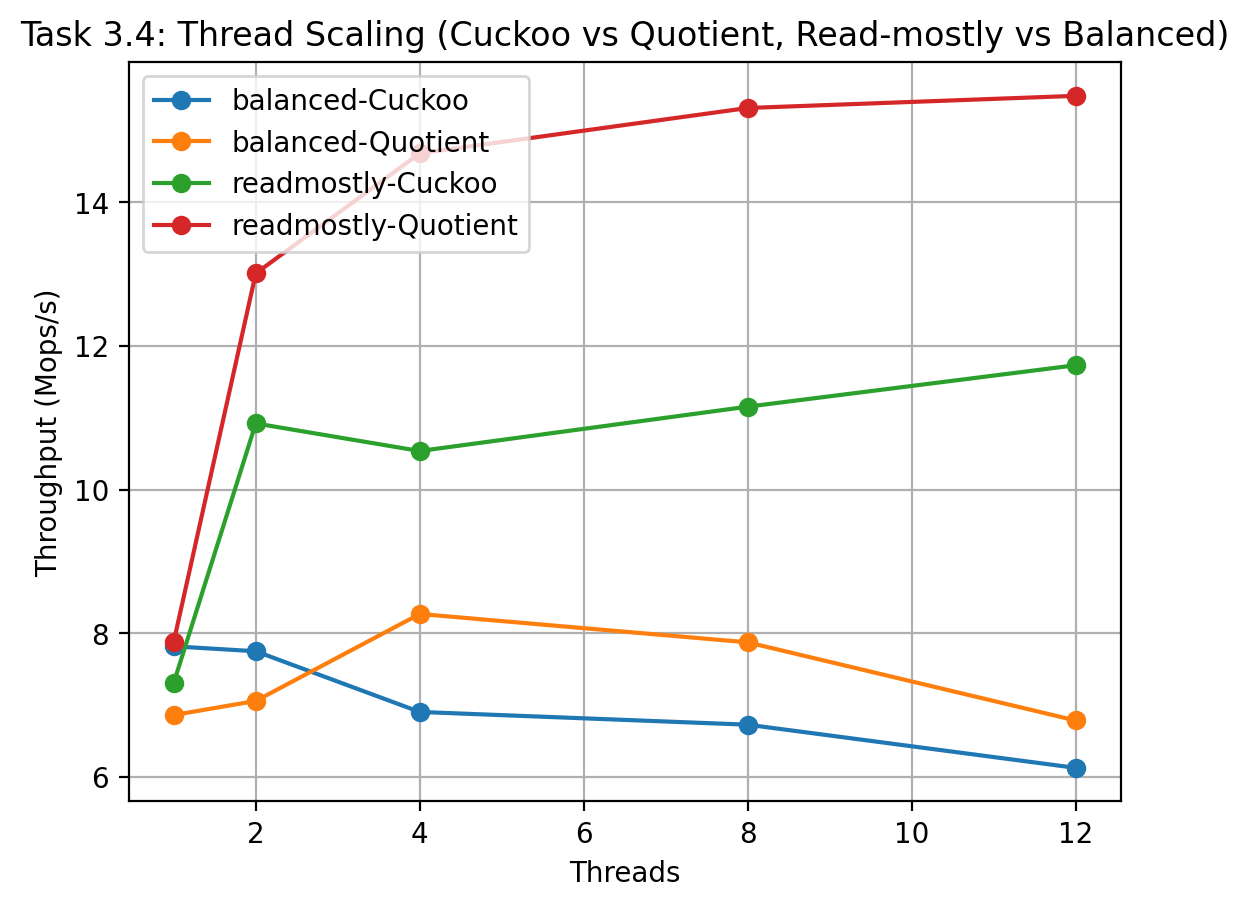 | 
|:----------------------------------------------------:|

The figure shows that around 8 threads is a clear scaling knee. Throughput increases quickly from 1 to 2 threads and continues to improve up to about 8 threads, but beyond that the gains are very small. In read-mostly workloads, performance largely saturates after 8 threads. In balanced workloads, throughput actually drops after 4–8 threads, with a decline of about 15–20% at 12 threads due to lock contention and cache interference. This indicates that contention, not computation, becomes the bottleneck once thread count is high.